# Demo of hierarchical clustering and consensus clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from clustertools.load_data import load_fuzzy_data
from scipy.spatial import distance
from copy import deepcopy
from timeit import default_timer as timer
from datetime import timedelta
import importlib
%matplotlib inline

In [2]:
from clustertools.models import consensus
from clustertools.models import similarity
from clustertools.models import density
from clustertools.models import distance as cl_dist

In [3]:
fuzzy = load_fuzzy_data()
len(fuzzy)

2309

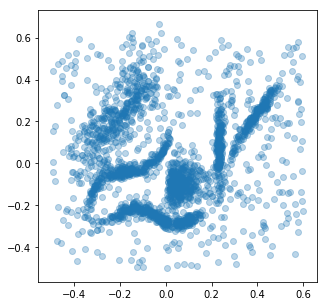

In [4]:
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[:,0], fuzzy[:,1],alpha=.3)

In [5]:
fuzzy_copy = deepcopy(fuzzy)
np.random.shuffle(fuzzy)

Set some parameters

### Hierarchical clustering

Set some parameters

In [6]:
k = 10 # number of clusters to go down to
stop_dist = 0.3
num_stop_crit = 1
stride = 2
data = fuzzy[::stride]
n = len(data) # number of data points
print(n)
link = 'average'
#link = 'complete'
#link = 'single'
metric='euclidean'

1155


Fit hierarchical clustering object and plot results

Hierarchical clustering terminated.
Finished after 0:00:07.654097
Stopping cluster number was reached.
Current number of clusters: 10
Stopping distance was reached.
Current minimum cluster distance: 0.3


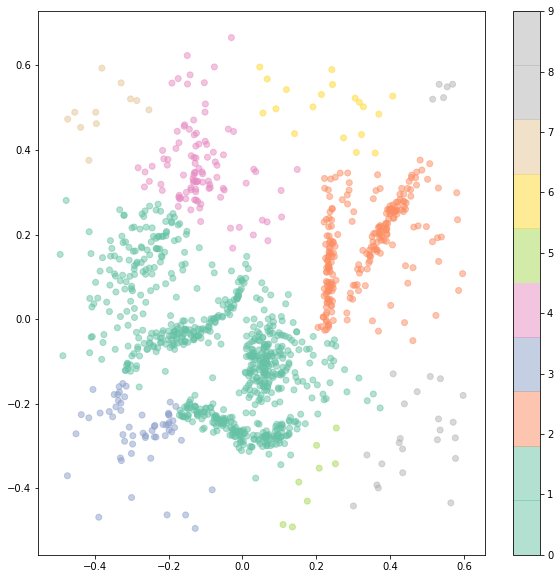

In [7]:
hiercl_obj = similarity.HierarchicalClustering(data, link=link, num_stop_crit=num_stop_crit, metric=metric, k=k, stop_dist=stop_dist)
hiercl_obj.fit()
labels = hiercl_obj.cluster_labels
plt.figure(figsize=(10, 10))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

### Consensus clustering
First fit some other clustering methods

In [8]:
dbscan_obj = density.DBSCAN(data, eps=0.03, minPts=10)
dbscan_obj.fit()
labels = dbscan_obj.cluster_labels
for i in range(len(labels)):
    if labels[i] == 'noise':
        labels[i] = 0
#plt.figure(figsize=(5, 5))
#plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', dbscan_obj._n_clusters), alpha=.5)
#plt.colorbar()

Detected 8 clusters
Finished after 0:00:00.108598
Rate of noise in dataset: 0.323810


In [9]:
kmeans_obj = cl_dist.KMeans(data, 10)
kmeans_obj.fit()
labels = kmeans_obj.cluster_labels
#plt.figure(figsize=(5, 5))
#plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
#plt.colorbar()

terminated by break condition
6 iterations until termination.
Finished after 0:00:00.008655
max within-cluster distance to center: 0.370369
mean within-cluster distance to center: 0.095544
sum of within cluster squared errors: 14.072131


In [10]:
spectral_obj = similarity.SpectralClustering(data, k=10, bandwidth=0.1)
spectral_obj.fit()
labels = spectral_obj.cluster_labels
#plt.figure(figsize=(5, 5))
#plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
#plt.colorbar()

Constructing gaussian similarity matrix
Computing generalized Laplacian eigenproblem


KMeans initialization on eigenvectors...
terminated by break condition
8 iterations until termination.
Finished after 0:00:00.027975
max within-cluster distance to center: 0.443867
mean within-cluster distance to center: 0.046010
sum of within cluster squared errors: 4.629949
KMeans terminated. 

Finished after 0:00:16.074028


Set some parameters of consensus

In [11]:
stride = 2
data = fuzzy[::stride]
n = len(data)

#clusterings = [spectral_obj, dbscan_obj, kmeans_obj, hiercl_obj]
clusterings = [spectral_obj, kmeans_obj, hiercl_obj]
#recluster_what = 'clusters'
recluster_what = 'points'
how = 'hierarchical'
#how = 'spectral'
k = 8 # how many clusters to produce

Hierarchical clustering terminated.
Finished after 0:00:06.533017
Stopping cluster number was reached.
Current number of clusters: 8
Current minimum cluster distance: 0.77
Consensus clustering terminated.
Finished after 0:00:07.338607
ANMI (average normalized mutual information) of consensus with clusterings: 0.821


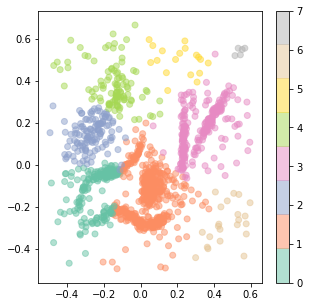

In [12]:
consensus_obj = consensus.Consensus(clusterings=clusterings, k=k, recluster_what=recluster_what, how=how)
consensus_obj.fit()
labels = consensus_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

### Strenth of consensus clustering

Generate data

PUT THIS INTO LOAD-DATA!!

In [13]:
# Generate blobs data with variances not always equal
from sklearn.datasets import make_blobs
def different_density_blobs():
    n_samples = 1500
    random_state = 3
    #k=3
    X, y = make_blobs(n_samples=n_samples, cluster_std=[1.5, 2.5, 2.5], random_state=random_state)
    data = np.vstack((X[y == 0][:500], X[y == 1][:200], X[y == 2][:200]))
    return data

In [14]:
from clustertools.load_data import load_spiral_data, scale_data
#data = load_spiral_data(scale = 'True')
data = different_density_blobs()

Fit some KMeans and DBSCAN objects

In [15]:
no_labels = [0] * len(data)
num_objects = 5
dbscan_objects = [None] * num_objects
kmeans_objects = [None] * num_objects
dbscan_obj = None
kmeans_obj = None

# Fit some DBSCAN objects
eps_array = np.linspace(0.5, 1.5, num_objects)
minPts_start = 5
minPts_array = np.arange(minPts_start, minPts_start + num_objects)
for i, (eps, minPts) in enumerate(zip(eps_array, minPts_array)):
    dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=False)
    dbscan_obj.fit()
    dbscan_objects[i] = dbscan_obj

# Fit some KMeans objects
num_clusters_start = 2
num_clusters_array = np.arange(num_clusters_start, num_clusters_start + num_objects)
for i, k in enumerate(num_clusters_array):
    kmeans_obj = cl_dist.KMeans(data, k=k, verbose=False)
    kmeans_obj.fit()
    kmeans_objects[i] = kmeans_obj

Find a consensus

In [16]:
# Fit consensus
clusterings = [*kmeans_objects, *dbscan_objects]
recluster_what = 'points'
how = 'spectral'
k=3
consensus_obj = consensus.Consensus(clusterings=clusterings, k=k, recluster_what=recluster_what, how=how, verbose=False)
consensus_labels = consensus_obj.cluster_labels

Plot results

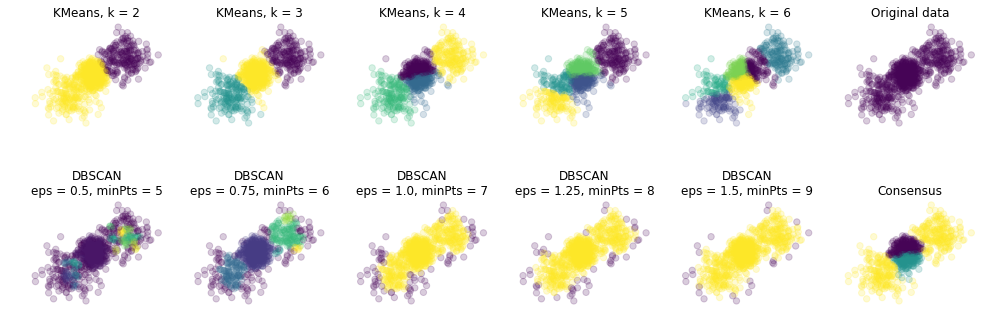

In [17]:
# Put labels in right order in to the labels array
labels = []
for obj in kmeans_objects:
    labels.append(obj.cluster_labels)
labels.append(no_labels)
for obj in dbscan_objects:
    labels.append(consensus_obj._noise_to_zero(obj).cluster_labels)
labels.append(consensus_labels)

# Init plotting arrangement
num_plots = len(kmeans_objects) + len(dbscan_objects) + 2
num_subplts_per_row = 6
num_rows = num_plots // num_subplts_per_row
num_cols = min(num_subplts_per_row, num_plots)
f, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

# Plot labels
for i, ax in enumerate(axarr.flat):
    #format_square(ax, min(data[:, 0]), max(data[:, 0]), min(data[:, 1]), max(data[:, 1]))
    ax.set_aspect('equal')
    ax.scatter(data[:, 0], data[:, 1], s=40, c=labels[i], alpha=0.2)
    # RAUM NOCH EINRÜGEN
    ax.axis('off')
    if i < num_subplts_per_row - 1:
        ax.set_title('KMeans, k = {0}'.format(num_clusters_array[i]))
    elif i == num_subplts_per_row - 1:
        ax.set_title('Original data')
    elif i < num_plots - 1:
        ax.set_title('DBSCAN\neps = {0}, minPts = {1}'.format(eps_array[i-num_subplts_per_row], minPts_array[i-num_subplts_per_row]))
    else:
        ax.set_title('Consensus')
plt.show()

In [18]:
#f.savefig('consensus_good_kmeans.png', format='png')

### NMI stuff

In [56]:
# NMI information
print(consensus_obj.anmi)
print(consensus_obj.compute_nmi(consensus_obj.cluster_labels, kmeans_obj.cluster_labels))
print(consensus_obj.compute_nmi(consensus_obj.cluster_labels, kmeans_obj2.cluster_labels))
print(consensus_obj.compute_nmi(consensus_obj.cluster_labels, consensus_obj._noise_to_zero(dbscan_obj).cluster_labels))
print(consensus_obj.compute_nmi(consensus_obj.cluster_labels, consensus_obj._noise_to_zero(dbscan_obj2).cluster_labels))

0.782500226991
1.0
1.0
0.510933494073
0.619067413892


### Which consensus heuristic works best (according to NMI?)

Compare all four consensus heuristics in a 2-by-2-plot, next to their ANMIs (for some example, e.g. the cases above, or fuzzy!)

### Parameter search with consensus clustering

Fit some DBSCAN objects with different parameters (maybe just the 5 ones from above?) and take the one with best consensus. (Plot nice bar diagram for that -> seaborn.) Should work in that case!